<a href="https://colab.research.google.com/github/eddiechn/oct-disease/blob/main/OCT_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf


# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.17.0


In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'kermany2018:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F17839%2F23942%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240807%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240807T145436Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D51261fa84edaf2753c953eccff6b49b8a134aac12b622e5fb11e5d8a86ebabff0d238b6455a3b4ab50680e875cac6c51333e79428dc0eca8069721fa5cb290e308a96f948df05e4eacbb39d113d70c16d2b804df6ab16fae50eeb44943baec3b6f01076631536f5440ef15a7131ef6cac7ca179d1162a7f3e1f33692124d059aa394241521dc8a29ff64116800d6313fa17f0702028a5101d33106caa0fad6d5d8dc7c540c3ce66d03632ffc774bc2f6784d968d041b3e1c363a4c4df4b32d7a28186ac6c0ecdd569617778d7097692c233f8521f5a2917df97a874776b2711de0f9503516a9bc4510da017cbec4ecc938aadffebde107a671aaf35b62b2edba'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 11644282751 bytes downloaded
Downloaded and uncompressed: kermany2018
Data source import complete.


In [3]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from PIL import Image
import matplotlib.pyplot as plt

In [14]:
main_path = "/kaggle/input/kermany2018/OCT2017 "


# val, test, train have already been split in the kaggle database

train_dir = f"{main_path}/train"
val_dir = f"{main_path}/val"
test_dir = f"{main_path}/test"


In [15]:
# paths
print(train_dir)
print(val_dir)
print(test_dir)

/kaggle/input/kermany2018/OCT2017 /train
/kaggle/input/kermany2018/OCT2017 /val
/kaggle/input/kermany2018/OCT2017 /test


In [16]:
# diseases
diseases = os.listdir(train_dir)

diseases


['NORMAL', 'DRUSEN', 'CNV', 'DME']

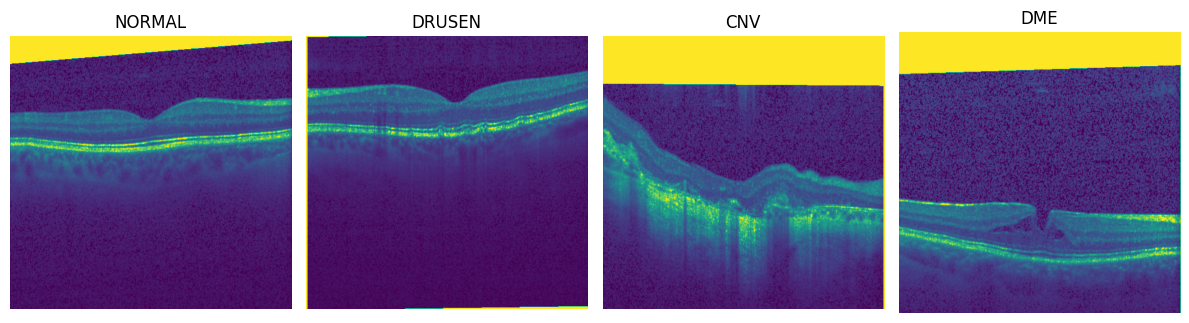

In [17]:


# Create a 2x2 subplot
fig, axs = plt.subplots(1, 4, figsize=(12, 5))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Ensure we don't try to plot more images than available axes
for i, ax in enumerate(axs):
    if i < len(diseases):
        disease = diseases[i]
        disease_dir = os.path.join(train_dir, disease)

        # List all images in the disease directory
        images = os.listdir(disease_dir)

        # Select a random image
        img_path = os.path.join(disease_dir, np.random.choice(images))

        # Load and display the image
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.set_title(disease)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

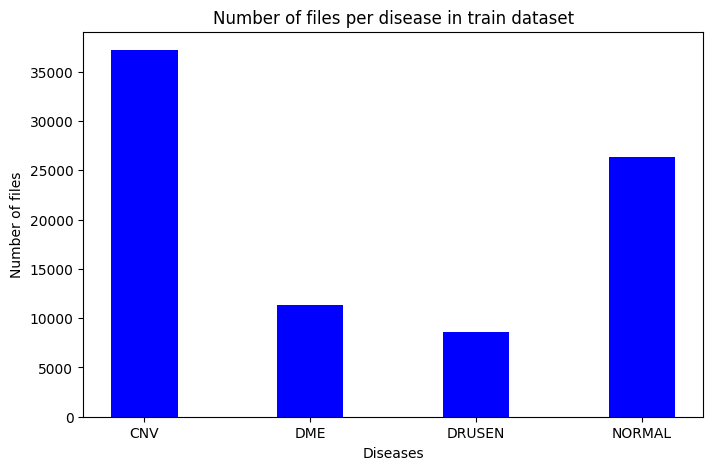

In [18]:
dataset = train_dir
image_counts = {"CNV": 0, "DME": 0, "DRUSEN": 0, "NORMAL": 0}

for disease in image_counts.keys():
    disease_dir = os.path.join(dataset, disease)
    image_counts[disease] = len(os.listdir(disease_dir))

diseases = list(image_counts.keys())
count = list(image_counts.values())

fig = plt.figure(figsize=(8,5))

plt.bar(diseases, count, color="blue", width = 0.4)

plt.xlabel("Diseases")
plt.ylabel("Number of files")
plt.title("Number of files per disease in train dataset")
plt.show()

# Training model using InceptionV3 pretrained model

In [19]:
batch_size = 32

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D,Input,concatenate, Lambda

In [21]:
image_gen = ImageDataGenerator(rescale=1/255,
                              shear_range=0.15,
                              zoom_range=0.2,
                              horizontal_flip=True,
                               rotation_range=25,
                              )

In [22]:
train_image_gen = image_gen.flow_from_directory(train_dir,
                                                target_size=(299, 299),
                                                batch_size=32,
                                                color_mode="grayscale",
                                                shuffle=True,
                                                class_mode="categorical"
                                               )

Found 83484 images belonging to 4 classes.


In [23]:
test_image_gen = image_gen.flow_from_directory(test_dir,
                                                target_size=(299, 299),
                                                batch_size=32,
                                                color_mode="grayscale",
                                                shuffle=True,
                                               class_mode="categorical"
                                               )

Found 968 images belonging to 4 classes.


In [24]:
def create_model() :

  input_shape = (299, 299, 1)

  inputs = Input(shape=input_shape)

  # three channels
  x = tf.keras.layers.Concatenate()([inputs, inputs, inputs])

  inception_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=x)

  x = Flatten()(inception_model.output)

  # Fully connected layers
  x = Dense(512, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)

  x = Dense(256, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)

  x = Dense(64, activation='relu')(x)


  # output
  outputs = Dense(4, activation='softmax')(x)

  final_model = tf.keras.Model(inputs=inputs, outputs=outputs)

  final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return final_model

final_model = create_model()

final_model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 299, 299, 3)    │              0 │ input_layer[0][0],     │
│                           │                        │                │ input_layer[0][0],     │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├──────────────────────

 Total params: 89,063,268 (339.75 MB)

 Trainable params: 89,027,300 (339.61 MB)

 Non-trainable params: 35,968 (140.50 KB)

In [26]:

# Define log directory
logdir = 'logs'

# TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='auto',
    patience=4,
    restore_best_weights=True
)

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath='InceptionV3_tuning.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto'
)


In [27]:
model_results = final_model.fit(train_image_gen,epochs=10,
                    validation_data=test_image_gen,
                    callbacks=[tensorboard_callback, early_stopping, checkpoint])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.7303 - loss: 0.7409
Epoch 1: val_loss improved from inf to 0.26020, saving model to InceptionV3_tuning.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 1409s 499ms/step - accuracy: 0.7304 - loss: 0.7408 - val_accuracy: 0.9029 - val_loss: 0.2602
Epoch 2/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8959 - loss: 0.3055
Epoch 2: val_loss improved from 0.26020 to 0.21353, saving model to InceptionV3_tuning.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 1273s 476ms/step - accuracy: 0.8959 - loss: 0.3055 - val_accuracy: 0.9339 - val_loss: 0.2135
Epoch 3/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9121 - loss: 0.2595
Epoch 3: val_loss improved from 0.21353 to 0.12686, saving model to InceptionV3_tuning.keras
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 1207s 462ms/step - accuracy: 0.9121 - loss: 0.2595 - val_accuracy: 0.9587 - val_loss: 0.1269
Epoch 4/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9374 - loss: 0.1856
Epoc

KeyboardInterrupt: 

####